# Проект создания дашборда дата-вакансий из Телеграм-каналов

В рамках данного проекта необходимо выполнить:

1. Парсинг данных из необходимых Телеграм-каналов.

2. Обработать данные:

    - Выполнить соответствие типа данных.
    
    - Удалить полные дубликаты.
    
    - Удалить неявные дубликаты.
    
    
3. Выделить из текста вакансий:

    - Позицию вакансии.
    
    - Грейд.
    
    - Необходимые hard-skills.
    
    - Формат работы.
    
    - Город вакансии.
    
    
4. Сохранить необходимые столбцы в финальный дата-фрейм.

5. Создать дашборд вакансий и необходимых hard-skills.

## Парсинг вакансий из Телеграм-каналов

In [1]:
# установка библиотеки pyrogram для взаимодействия с API Телеграма, а также библиотеки tgcrypto (ее рекомендуют в документации к Pyrogram)
#!pip3 install pyrogram tgcrypto

In [2]:
# установка библиотеки python-dotenv для хранения ключей в файлах окружения, а не в коде
#!pip3 install python-dotenv

In [3]:
# импорт необходимых библиотек
import pyrogram
import requests
import numpy as np
from bs4 import BeautifulSoup
from dotenv import load_dotenv
import os
from pyrogram import Client
import pandas as pd
import json
from datetime import datetime
import re
from IPython.core.display import display, HTML, clear_output
import ipywidgets as widgets

In [4]:
# проверка версии библиотеки pyrogram
pyrogram.__version__

'2.0.26'

Сформируем 2 файла для парсинга факансий:

1. Файл авторизации клиента pyrogram (pyro_auth.py).
2. Файл парсинга вакансий в `telegram_vacances.csv` (pyro_run.py).

Будем парсить вакансии из следующих Телеграм-каналов:

- Business Intelligence HeadHunter
- Data Analytics Jobs
- Data Science Jobs / AI / NN / ML / DL / NLP
- Data jobs feed
- Data jobs — вакансии по data science, анализу данных, аналитике, искусственному интеллекту
- Job for Analysts & Data Scientists	

Файл авторизации (pyro_auth.py):

```
#импорт необходимых библиотек
from pyrogram import Client
import os
from dotenv import load_dotenv

#формирование пути к системному окружению
path = os.path.dirname(os.path.abspath(__file__))


#формирование полного пути к файлу dot.env
dotenv_path = os.path.join(path + '/dot.env')

#проверка наличия файла в системном окружении
# в случае наличия файла, выгрузим его
if os.path.exists(dotenv_path):
	load_dotenv(dotenv_path)

# присвоение API_ID и API_HASH из файла dot.env соответствующим переменным
API_ID = os.environ['API_ID']
API_HASH = os.environ['API_HASH']

#авторизация в API Телеграма с помощью библиотеки класса
#в случае успешной авторизации, отправим себе сообщение "Авторизация прошла успешно"
with Client ("my_account", API_ID, API_HASH) as app:
	app.send_message("me", "Авторизация прошла успешно")
```

Файл парсинга вакансий (pyro_run.py):
```
#импорт необходимых библиотек
from pyrogram import Client
import os
from dotenv import load_dotenv
import datetime
import pandas as pd

#формирование пути к системному окружению
path = os.path.dirname(os.path.abspath(__file__))

#формирование полного пути к файлу dot.env
dotenv_path = os.path.join(path + '/dot.env')

#проверка наличия файла в системном окружении
# в случае наличия файла, выгрузим его
if os.path.exists(dotenv_path):
	load_dotenv(dotenv_path)

# обозначение параметров авторизации
API_ID = os.environ['API_ID']
API_HASH = os.environ['API_HASH']

# обозначение каналов парсинга вакансий
targets = ['data_hr', 'biheadhunter', 'datajobschannel', 'datajob', 'foranalysts', 'datasciencejobs']

# список для всех вакансий
all_messages = []

# парсинг всех вакансий из указанных каналов
try:
	with Client("my_account", API_ID, API_HASH) as app:
		for target in targets:
			for message in app.get_chat_history(target, limit=app.get_chat_history_count(target)):
				all_messages.append([message.sender_chat, message.id, message.date, message.text, message.entities])
    
    # сохранение вакансий в дата-фрейм
	df = pd.DataFrame(all_messages)
    
    # обозначение названий столбцов
	df.columns = ["chat", "message_id", "date", "text", "entities"]
    
    # выгрузка дата-фрейма в csv-файл
	df.to_csv(path + '/telegram_vacances.csv', index=False)
    
    # сообщение об успешном парсинге
	print('Success: ', path + '/telegram_vacances.csv')
except Exception as e:
    
    # в случае ошибки, сообщение об ошибке
	print('Error: ', e)
```

Сохраним параметры авторизации API_ID и API_HASH в файл `dot.env`.

In [5]:
#формирование пути к файлу dot.env в системном окружении
dotenv_path = os.path.join('dot.env')

#проверка наличия файла в системном окружении
# в случае наличия файла, выгрузим его
if os.path.exists(dotenv_path):
    load_dotenv(dotenv_path)

In [6]:
#проверка корректной выгрузки файла dot.env
os.environ['DEMO']

'demo'

In [7]:
# API_ID и API_HASH из файла dot.env
API_ID = os.environ['API_ID']
API_HASH = os.environ['API_HASH']

Запустим указанные выше скрипты через Терминал.

## Обработка данных

После успешного парсинга вакансий считаем файл `telegram_vacances.csv` в переменную `df`.

In [8]:
# считывание файла telegram_vacances.csv в переменную df
df = pd.read_csv('telegram_vacances.csv')

In [9]:
df.head(30)

,chat,message_id,date,text,entities
0,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",261,2022-06-08 16:44:30,#Moscow #Москва #DataEngineer #ДатаИнженер #DE...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
1,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",260,2022-06-07 16:42:25,#вакансия #маркетинговыйаналитик #москва #гиб...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
2,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",259,2022-05-28 19:47:42,NaN,NaN
3,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",258,2022-05-26 18:23:53,NaN,NaN
4,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",257,2022-05-21 20:19:17,NaN,NaN
5,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",256,2022-05-19 19:23:11,#lookfor #russia #outstaff #fulltime \nВсем пр...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
6,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",255,2022-05-19 18:45:30,#vacancy #remote #big_query #hiring\n\nBIG QUE...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
7,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",254,2022-05-18 22:54:05,Стань дата-инженером с Яндекс Практикумом\n\nС...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
8,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",253,2022-05-13 15:01:46,Позиция: Marketing Analyst\nКомпания: CберЗвук...,"[\n {\n ""_"": ""MessageEntity"",\n ..."
9,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",252,2022-05-12 22:01:46,"В компанию ЦУМ требуется продуктовый аналитик,...","[\n {\n ""_"": ""MessageEntity"",\n ..."


In [10]:
# информация по дата-фрейму
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4075 entries, 0 to 4074
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chat        4075 non-null   object
 1   message_id  4075 non-null   int64 
 2   date        4075 non-null   object
 3   text        3719 non-null   object
 4   entities    3638 non-null   object
dtypes: int64(1), object(4)
memory usage: 159.3+ KB


Изменим тип данных поля `date`.

In [11]:
# изменение типа данных поля date с object на datetime
df['date'] = pd.to_datetime(df['date'])

Создадим новый столбец `vac_date`, в котором отбросим время из столбца `date` и оставим только дату.

In [12]:
# создание столбца vac_date с датой вакансии
df['vac_date'] = df['date'].dt.date

In [13]:
# информация по датафрему
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4075 entries, 0 to 4074
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   chat        4075 non-null   object        
 1   message_id  4075 non-null   int64         
 2   date        4075 non-null   datetime64[ns]
 3   text        3719 non-null   object        
 4   entities    3638 non-null   object        
 5   vac_date    4075 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 191.1+ KB


Теперь удалим строки, в которых нет текста вакансии.

In [14]:
# удаление строк, в которых отсутствует текст вакансии
df = df[~(df['text'].isna())]

In [15]:
# информацию по дата-фрейму
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3719 entries, 0 to 4073
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   chat        3719 non-null   object        
 1   message_id  3719 non-null   int64         
 2   date        3719 non-null   datetime64[ns]
 3   text        3719 non-null   object        
 4   entities    3638 non-null   object        
 5   vac_date    3719 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 203.4+ KB


Теперь удалим полные дубликаты.

In [16]:
# количество полных дубликатов
df['text'].duplicated().sum()

260

In [17]:
# полные дубликаты вакансий
df[df['text'].duplicated()]

,chat,message_id,date,text,entities,vac_date
22,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",239,2022-04-12 17:16:57,#работа #вакансия #job #fulltime #удаленка #de...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-04-12
72,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",185,2022-01-14 18:02:22,#москва #вакансия #аналитик #fulltime #office ...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-01-14
126,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",131,2021-10-28 20:41:43,Сейчас ищу Продуктового аналитика.\n\nОфис – м...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-10-28
166,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",91,2021-08-11 14:00:07,#работа #удаленка #офис #геймдев\nКомпания: Az...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-08-11
283,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",583,2021-12-02 21:15:17,#вакансия #tableau #москва #middle #senior #fu...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-12-02
...,...,...,...,...,...,...
3984,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",104,2020-05-19 20:46:44,#вакансия #МТС ИТ #job #Москва #офис #dataengi...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2020-05-19
3990,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",97,2020-04-30 15:07:13,#Вакансия #Офис #Python #BigData #MachineLearn...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2020-04-30
4049,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",34,2020-01-14 20:55:24,#Вакансия #Офис #Python #BigData #MachineLearn...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2020-01-14
4056,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",24,2019-12-11 17:32:23,#Вакансия #Офис #Python #BigData #MachineLearn...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2019-12-11


Видим, что полные дубликаты возникают из-за того, что hr выкладывают одну и ту же вакансию в разные каналы или выкладывают вакансию несколько раз с небольшим промежутком времени.

In [18]:
# удаление полных дубликатов
df = df.drop_duplicates(subset = ['text']).reset_index(drop=True)

In [19]:
# проверка количества полных дубликатов
df['text'].duplicated().sum()

0

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3459 entries, 0 to 3458
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   chat        3459 non-null   object        
 1   message_id  3459 non-null   int64         
 2   date        3459 non-null   datetime64[ns]
 3   text        3459 non-null   object        
 4   entities    3378 non-null   object        
 5   vac_date    3459 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 162.3+ KB


В дата-фрейме присутствуют неявные дубликаты. Давайте посмотрим на такие вакансии.

In [21]:
# достаем текст вакансии с индексом 29
df.loc[1835]['text']

'#работа #офис\nFull-time,Odessa,Ukraine\nМы сейчас сотрудничаем с US based компанией, инвестором которой является один из фаундеров Softserve. Компания - data driven marketing platform, Wyzoo. Проект заключается в работе с данными для оптимизации маркетинговых кампаний за счет аналитики и предиктивного анализа различных видов рекламы, а также сегментации целевой аудитории. Ребята открывают офис в Одессе, где планируют собрать максимальное количество Data scientists($2,000 - $3,500) и jn.Data Engineers($500 - $1,200),Data Engineers($1,200 - $2,500).Бонус за рекомендацию. \nНа данный момент открыто несколько вакансий: \n1.  https://jobs.dna325.com/jobs/wyzoo-country-manager/ \n2.  https://jobs.dna325.com/jobs/data-scientist-senior-middle/\n3.  https://jobs.dna325.com/jobs/data-engineers-mid/'

Далее с помощью метода `str.contains()` найдем вакансии, у которых начало совпадает с началом текста вакансии с индексом 29.

In [22]:
# ищем вакансии, 
df[df['text'].str.contains('Мы сейчас сотрудничаем с US based компанией, инвестором которой является один из фаундеров Softserve. Компания - data driven marketing platform, Wyzoo. Проект заключается в работе с данными для оптимизации маркетинговых кампаний за счет аналитики и предиктивного анализа различных видов рекламы,')]

,chat,message_id,date,text,entities,vac_date
1835,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",46,2019-04-08 21:50:33,"#работа #офис\nFull-time,Odessa,Ukraine\nМы се...","[\n {\n ""_"": ""MessageEntity"",\n ...",2019-04-08
1850,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",30,2019-03-20 15:28:09,#вакансия #python #Одесса #офис #fulltime #Dat...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2019-03-20
1853,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",27,2019-03-15 21:20:34,"Мы сейчас сотрудничаем с US based компанией, и...","[\n {\n ""_"": ""MessageEntity"",\n ...",2019-03-15


In [23]:
df.loc[1850]['text']

'#вакансия #python #Одесса #офис #fulltime #DataScientists #DataEngineers\n\nМы сейчас сотрудничаем с US based компанией, инвестором которой является один из фаундеров Softserve. Компания - data driven marketing platform, Wyzoo. Проект заключается в работе с данными для оптимизации маркетинговых кампаний за счет аналитики и предиктивного анализа различных видов рекламы, а также сегментации целевой аудитории. Ребята открывают офис в Одессе, где планируют собрать максимальное количество:\nJnr.Data Scientists $500 - $1,000 \nData Scientists $2,000 - $3,000\nJnr.Data Engineers $500 - $1,000\nData Engineers $1,200 - $2,000\n1.  https://jobs.dna325.com/jobs/wyzoo-country-manager/ \n2.  https://jobs.dna325.com/jobs/data-scientist-senior-middle/\n3.  https://jobs.dna325.com/jobs/data-engineers-mid/\n4.  https://jobs.dna325.com/jobs/junior-data-scientist/\nFull-time,Odessa,Ukraine\n#работа #офис'

In [24]:
df.loc[1853]['text']

'Мы сейчас сотрудничаем с US based компанией, инвестором которой является один из фаундеров Softserve. Компания - data driven marketing platform, Wyzoo. Проект заключается в работе с данными для оптимизации маркетинговых кампаний за счет аналитики и предиктивного анализа различных видов рекламы, а также сегментации целевой аудитории. Ребята открывают офис в Одессе, где планируют собрать максимальное количество Data scientists и Data Engineers. На данный момент открыто несколько вакансий:\n1.  https://jobs.dna325.com/jobs/wyzoo-country-manager/  2.  https://jobs.dna325.com/jobs/data-scientist-senior-middle/ \n3.  https://jobs.dna325.com/jobs/data-engineers-mid/'

Сравним 2 текста с помощью сервиса https://textcompare.ru/app.

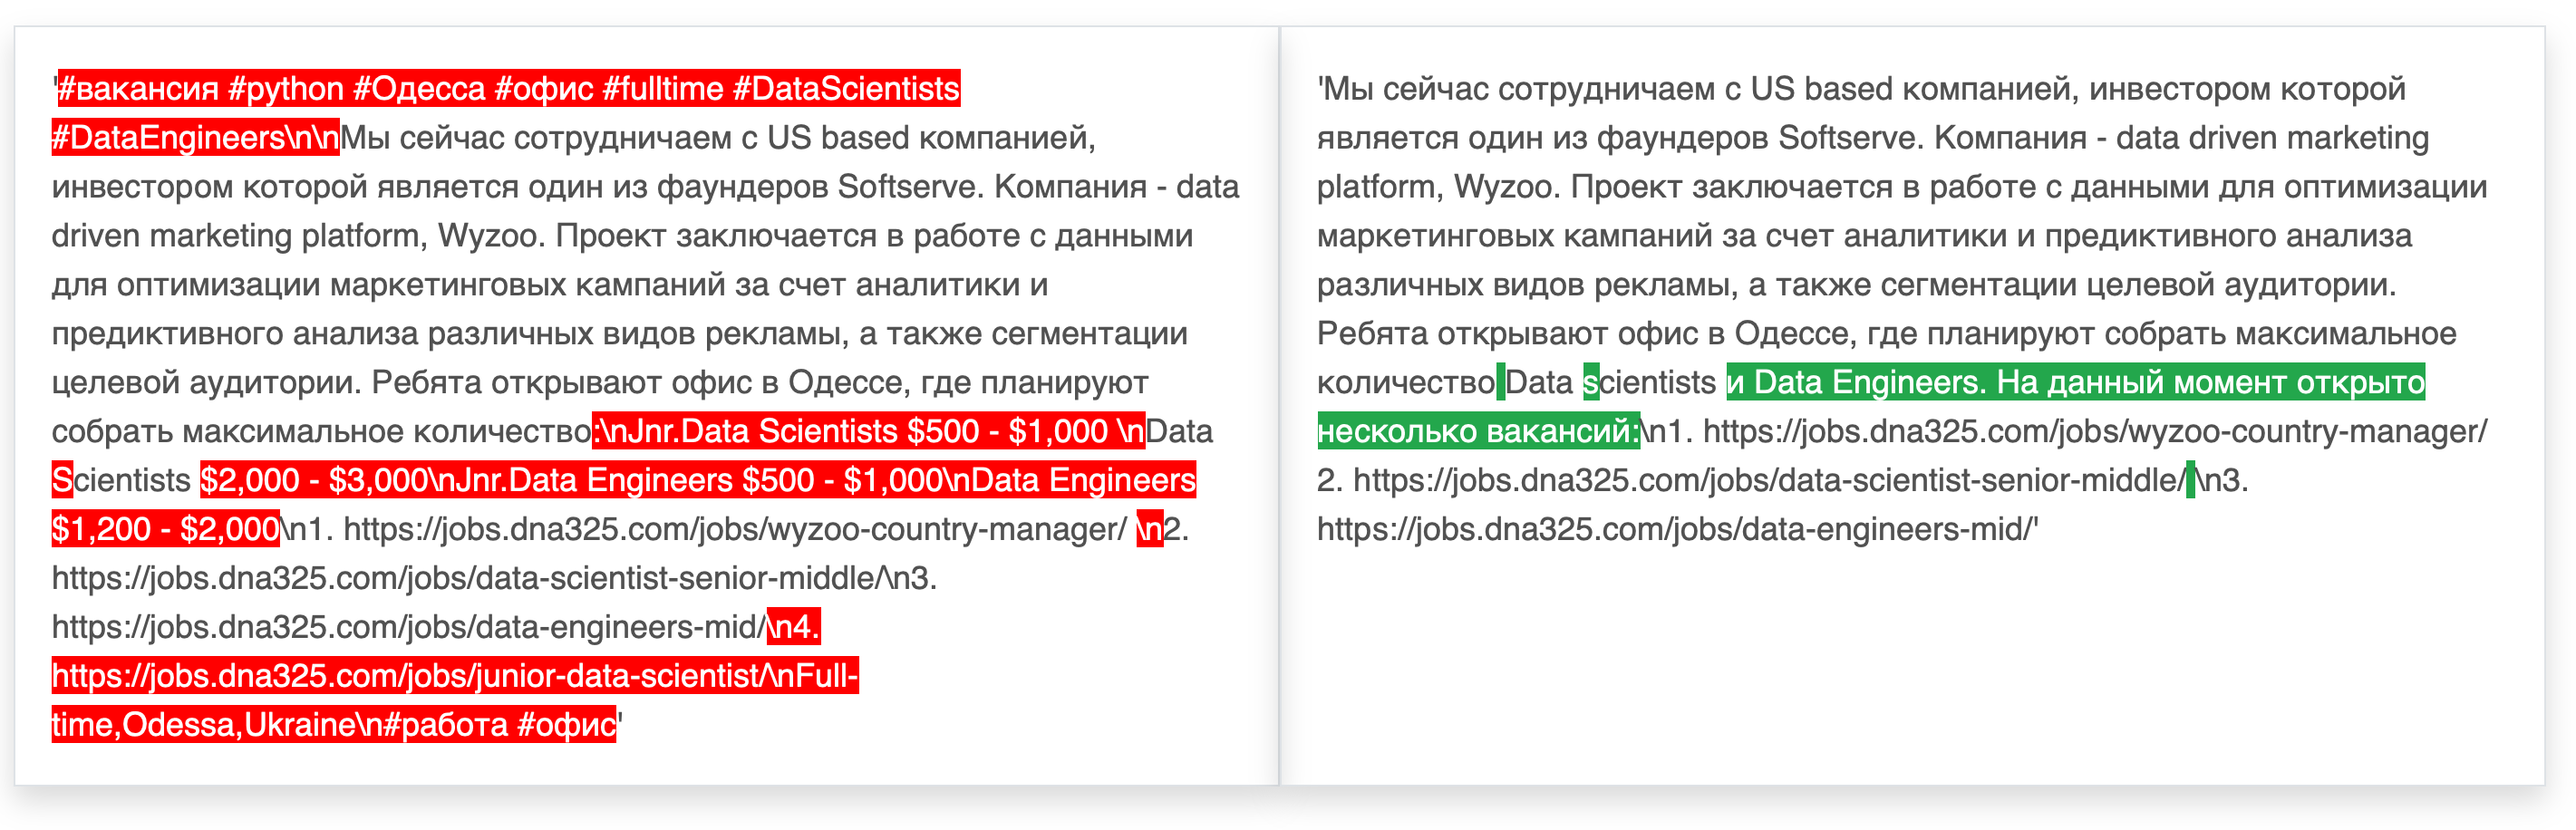

В левую вакансию добавили зарплатную вилку и хэштеги, но, по сути, это дубликат.

Кейс выше показал, что нам нужна функция, которая будет определять неявные дубликаты вакансий.

Наша функция будет работать следующим образом:

1. Брать первые 130 символов вакансии. Как правило, этого количества хватает для идентификации неявных дубликатов.

2. Искать эти 130 символов во всех остальных вакансиях.

3. В случае совпадения, добавлять индекс вакансии в список дубликатов.

4. Брать последние 130 символов вакансии.

5. Выполнять п.2.

6. В случае совпадения и отсутствия индекса в списке дубликатов, добавлять индекс вакансии в список.

Перед написанием функции заменим некоторые символы, которые могут вызвать ошибку в работе метода `str.contains()`, на равнозначные.

In [25]:
# замена символов, которые могут вызвать ошибку в работе метода
df['text'] = df['text'].str.replace('(', '"')
df['text'] = df['text'].str.replace(')', '"')
df['text'] = df['text'].str.replace('+', 'плюс')
df['text'] = df['text'].str.replace('•', '-')
df['text'] = df['text'].str.replace('\\', '/')
df['text'] = df['text'].str.replace('*', '#')
df['text'] = df['text'].str.replace('?', ' ')

<ipython-input-25-709a0f07fa0d>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('(', '"')
<ipython-input-25-709a0f07fa0d>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace(')', '"')
<ipython-input-25-709a0f07fa0d>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('+', 'плюс')
<ipython-input-25-709a0f07fa0d>:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, sin

Теперь отсортируем дата-фрейм по столбцу `date`.

In [26]:
df = df.sort_values(by='date', ascending=True).reset_index(drop=True)

In [27]:
# реализация функции dupl_searching
def dupl_searching():
    dupl_ind_list_start = [] # список для индексов дубликатов первых 130 символов
    dupl_ind_list_end = [] # список для индексов дубликатов последних 130 символов
    dupl_list_start = [] # список для дубликатов первых 130 символов
    dupl_list_end = [] # список для дубликатов последних 130 символов
    
    for i in range(len(df['text'])):
        
        # проверка на совпадение первых 130 символов
        if len(df[df['text'].str.contains(df.loc[i]['text'][0:130])]) > 1:
            
            # если совпадение есть, проходит проверка на отсутствие вакансии в списке dupl_list_start
            if df.loc[i]['text'][0:130] not in(dupl_list_start):
                
                # если вакансия отсутствует в dupl_list_start добавляем индекс вакансии в dupl_ind_list_start
                # также добавляем вакансию в dupl_list_start для последующих проверок
                dupl_list_start.append(df.loc[i]['text'][0:130]) 
                dupl_ind_list_start.append(i)
    
    for i in range(len(df['text'])):
        
        # проверка на совпадение последних 130 символов
        if len(df[df['text'].str.contains(df.loc[i]['text'][-130:-1])]) > 1:
            
            # если совпадение есть, проходит проверка на отсутствие вакансии в списке dupl_list_end и отсутствия индекса в dupl_ind_list_start
            # проверка на отсутствие индекса в dupl_ind_list_start необходима, чтобы индексы не дублировались
            if df.loc[i]['text'][-130:-1] not in (dupl_list_end) and i not in(dupl_ind_list_start):
                
                # если вакансия отсутствует в dupl_list_end и ее индекс отсутствует в dupl_ind_list_start, добавляем индекс вакансии в dupl_list_end
                # также добавляем вакансию в dupl_list_start для последующих проверок
                dupl_list_end.append(df.loc[i]['text'][-130:-1])
                dupl_ind_list_end.append(i)
                
    global dupl_ind_list_com
    
    # складываем 2 списка индексов дублирующихся вакансий
    dupl_ind_list_com = (dupl_ind_list_start + dupl_ind_list_end)
    print(dupl_ind_list_com)

In [28]:
# вызываем функцию
dupl_searching()

[8, 20, 29, 55, 61, 63, 64, 83, 94, 98, 100, 119, 124, 189, 194, 197, 224, 236, 237, 246, 259, 285, 300, 319, 334, 369, 370, 387, 420, 434, 443, 455, 543, 666, 681, 699, 724, 741, 748, 767, 783, 785, 820, 821, 825, 832, 855, 879, 885, 934, 960, 969, 993, 1010, 1025, 1041, 1053, 1054, 1067, 1079, 1102, 1130, 1216, 1228, 1279, 1284, 1300, 1307, 1308, 1348, 1352, 1388, 1424, 1448, 1495, 1507, 1510, 1518, 1520, 1528, 1532, 1559, 1570, 1588, 1602, 1605, 1615, 1624, 1653, 1741, 1743, 1746, 1772, 1780, 1784, 1793, 1824, 1840, 1887, 1916, 1944, 1949, 1951, 1953, 1961, 1966, 1990, 1991, 2029, 2052, 2089, 2097, 2109, 2115, 2141, 2147, 2151, 2155, 2171, 2189, 2198, 2201, 2215, 2216, 2223, 2228, 2244, 2249, 2267, 2271, 2310, 2311, 2322, 2340, 2343, 2360, 2372, 2387, 2428, 2440, 2502, 2524, 2537, 2573, 2580, 2605, 2688, 2694, 2774, 2824, 2830, 2831, 2839, 2874, 2887, 2916, 2920, 2942, 3017, 3073, 3082, 3099, 3106, 3117, 3150, 3154, 3160, 3175, 3188, 3189, 3235, 3259, 3265, 3281, 3289, 3309, 3310, 4

In [29]:
len(dupl_ind_list_com)

410

Видим, что в дата-фрейме 410 неявных дубликатов. Удалим их из дата-фрейма.

In [30]:
# удаление неявных дубликатов
df = df.query('index not in @dupl_ind_list_com').reset_index(drop=True)

В дата-фрейме некоторые вакансии могут содержать более 2 дубликатов, поэтому функцию `dupl_searching()` необходимо вызывать несколько раз.

In [31]:
# повторный вызов функции
dupl_searching()

[1040, 1367, 1428, 1482, 1705, 1822, 2297, 2475, 183, 303, 306, 343, 413, 820, 1007, 1177, 1182, 1297, 1339, 1771, 1806, 1842, 1896, 1967, 2275, 2301, 2348, 2566, 2683, 2743, 2801, 2821, 2846, 2943, 2970]


In [32]:
# удаление неявных дубликатов
df = df.query('index not in @dupl_ind_list_com').reset_index(drop=True)

In [33]:
# повторный вызов функции
dupl_searching()

[1355, 1534, 2183, 322, 773, 1082, 1464, 1795, 1893, 2817]


Теперь проанализируем оставшиеся индексы в ручную.

**Анализ вакансии с индексом 1355**

In [34]:
df[df['text'].str.contains(df.loc[1355]['text'][0:130])]

,chat,message_id,date,text,entities,vac_date
747,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",281,2020-10-28 16:40:39,DBA/Data Engineer\nот 60 000 до 100 000 руб. н...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2020-10-28
1355,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",460,2021-06-08 20:37:22,Robocash Group - международный fintech-холдинг...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-06-08
1447,"{\n ""_"": ""Chat"",\n ""id"": -1001291755040,...",489,2021-07-08 17:07:04,Robocash Group - международный fintech-холдинг...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-07-08


In [35]:
df.loc[747]['text']

'DBA/Data Engineer\nот 60 000 до 100 000 руб. на руки\nОпыт: 1-3 года\nЛокация: Кемерово\n\nО компании:\nRobocash Group - международный fintech-холдинг, успешно развивающийся в Европе и Азии с 2013 года и специализирующийся на частных инвестициях и потребительском кредитовании "как в режиме онлайн, так и в автономном режиме".\nКомпании нашей группы запущены и успешно работают в 8 странах мира "Россия, Казахстан, Испания, Латвия, Филиппины, Индонезия, Вьетнам, Индия". Мы постоянно расширяем географию нашего присутствия, выходим на новые рынки, ставим перед собой новые амбициозные задачи.\nПолучаешь удовольствие от IaC  Хочешь деплоить сервисы, которые будут работать в условиях географической распределенности на половину Земного шара \n\nЗадачи:\n\nУчастие в проектировании, организация и контроль потоков данных "cdc, etl"\nРазработка новых и доработка существующих процедур/флоу.\nАдминистрирование баз данных.\n\nТребования:\n\nОпыт использования linux-систем от 1 года\nЭкспертное владени

In [36]:
df.loc[1355]['text']

'Robocash Group - международный fintech-холдинг, успешно развивающийся в Европе и Азии с 2013 года и специализирующийся на частных инвестициях и потребительском кредитовании "как в режиме онлайн, так и в автономном режиме".\nКомпании нашей группы запущены и успешно работают в 8 странах мира "Россия, Казахстан, Испания, Латвия, Филиппины, Индонезия, Вьетнам, Индия". Мы постоянно расширяем географию нашего присутствия, выходим на новые рынки, ставим перед собой новые амбициозные задачи.\n\nВ настоящий момент мы ищем Разработчика DWH.\n\nОбязанности:\n-  Проектирование и разработка структур хранения данных в DWH.\n-  Проектирование, разработка и поддержка процессов извлечения, преобразования и загрузки данных в DWH.\n-  Проектирование, разработка и поддержка витрин данных на основе данных DWH.\n\nТребования:\n-  Высшее образование.\n-  Хорошие знания SQL.\n-  Опыт работы с реляционными базами данных "MS SQL, PostgreSQL, т.д.".\n-  Опыт работы с ETL/ELT-инструментами "MS SSIS".\n-  Пониман

In [37]:
df.loc[1447]['text']

'Robocash Group - международный fintech-холдинг, успешно развивающийся в Европе и Азии с 2013 года и специализирующийся на частных инвестициях и потребительском кредитовании "как в режиме онлайн, так и в автономном режиме".\nКомпании нашей группы запущены и успешно работают в 8 странах мира "Россия, Казахстан, Испания, Латвия, Филиппины, Индонезия, Вьетнам, Индия". Мы постоянно расширяем географию нашего присутствия, выходим на новые рынки, ставим перед собой новые амбициозные задачи.\n\nВ настоящий момент мы ищем в команду BI разработчика.\n\nКакие задачи предстоит решать:\n-  Разрабатывать дашборды и отчёты для менеджмента и мониторинга качества существующих бизнес-процессов в компании по направлениям риски / маркетинг / оперейшнс;\n-  Сбирать и анализировать требования от заказчиков;\n-  Работать с качеством данных, искать и устранять ошибки;\n-  Оптимизировать существующие отчеты "повышать качество визуализации, скорость отработки отчетов, унификацию";\n-  Поддерживать пользователе

Видим, что данные вакансии не дублируют друг друга.

**Анализ вакансии с индексом 1534**

In [38]:
df[df['text'].str.contains(df.loc[1534]['text'][0:130])]

,chat,message_id,date,text,entities,vac_date
1470,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",574,2021-07-14 23:45:07,#dataengineer #вакансия #работа #job #etl #sql...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-07-14
1534,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",601,2021-08-05 13:20:16,Привет! Мы — Вебиум. Нескучная онлайн-школа дл...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-08-05


In [39]:
df.loc[1470]['text']

'#dataengineer #вакансия #работа #job #etl #sql #clickhouse #Senler #BigQuery #OWOX #python\n\nData engineer\n\nПривет! Мы — Вебиум. Нескучная онлайн-школа для тех, кто готовится к экзаменам и хочет во всём разобраться.\n\nБолее 7 лет помогаем школьникам со всей России готовиться к ЕГЭ. Только в прошлом году с нами занималось более 41,5 тысячи студентов!\n\nВ 2021м мы третьи по темпу роста в первом квартале на рынке edtech, седьмые в сегменте школьного образования по итогам первого квартала, двадцатые в рейтинге edtech компаний за первый квартал и мы не собираемся останавливаться! 🙂\n\nКого мы ищем \nМы ищем дата-инженера, готового поддерживать data-driven культуру управления продуктом и маркетингом, обеспечивая всех заинтересованных данными для принятия аргументированных решений.\n\nЧто предстоит делать:\n- Создавать и оптимизировать ETL процессы выгрузки данных "разовые плюс автоматизация";\n- Контролировать качество данных;\n- Оптимизировать работу с базами данных;\n- Продумать стра

In [40]:
df.loc[1534]['text']

'Привет! Мы — Вебиум. Нескучная онлайн-школа для тех, кто готовится к экзаменам и хочет во всём разобраться.\n\nБолее 7 лет помогаем школьникам со всей России готовиться к ЕГЭ. Только в прошлом году с нами занималось более 41,5 тысячи студентов!\n\nВ 2021м мы третьи по темпу роста в первом квартале на рынке edtech, седьмые в сегменте школьного образования по итогам первого квартала, двадцатые в рейтинге edtech компаний за первый квартал и мы не собираемся останавливаться! 🙂\n\nКого мы ищем \nМы ищем дата-инженера, готового поддерживать data-driven культуру управления продуктом и маркетингом, обеспечивая всех заинтересованных данными для принятия аргументированных решений.\n\nЧто предстоит делать\n- Создавать и оптимизировать ETL процессы выгрузки данных "разовые плюс автоматизация";\n- Контролировать качество данных;\n- Оптимизировать работу с базами данных;\n- Продумать стратегию развития аналитической инфраструктуры с учетом потребностей бизнеса — выбор технологий и проектирование ар

Эти вакансии дублируют друг друга.

**Анализ вакансии с индексом 2183**

In [41]:
df[df['text'].str.contains(df.loc[2183]['text'][0:130])]

,chat,message_id,date,text,entities,vac_date
2183,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1233,2022-01-26 19:46:41,#вакансия #работа #data_engineer #junior #midd...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-01-26
2423,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1317,2022-03-01 19:27:47,#вакансия #работа #data_engineer #junior #midd...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-03-01
2473,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1332,2022-03-09 21:16:10,#вакансия #работа #data_engineer #junior #midd...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-03-09


In [42]:
df.loc[2183]['text']

'#вакансия #работа #data_engineer #junior #middle  #senior #fulltime \n\n🔎 Вакансия: Data engineer "Middle - Seniorплюс";\nЛокация: Москва "гибридный формат работы";\nЗанятость: полная;\nВилка: от 180к до 300к gross;\nКонтакт: @olga_chr, тел. плюс7 "985" 236-90-31\nКомпания: PА CSC-HR;\n\nВсем привет! \n\nВ крупную нефтегазохимическую компанию ищем Data engineer или опытных разработчиков, желающих вырасти в Data engineer. \n\n💼\nСуть проекта\n — развитие платформы данных как продукта.\n\n🍪 Мы предлагаем:\n— Комфортный рабочий график с гибким началом рабочего дня;\n— Оформление по ТК РФ;\n— Возможность удаленной работы;\n— Современный стек и гибкие методологии разработки, работа в команде высококлассных профессионалов из разных технологических областей;\n— Интересные и нестандартные задачи, которые требуют креатива и новых подходов, мы работаем в реальном секторе, наши пользователи - реальные люди;\n— Корпоративные льготы: ДМС, льготное страхование родственников, большой выбор внутренни

In [43]:
df.loc[2423]['text']

'#вакансия #работа #data_engineer #junior #middle  #senior #fulltime \n\n🔎 Вакансия: Data engineer "Middle - Seniorплюс";\nЛокация: Москва "гибридный формат работы";\nЗанятость: полная;\nВилка: от 180к до 300к gross;\nКонтакт: @olga_chr, тел. плюс7 "985" 236-90-31\nКомпания: PА CSC-HR;\n\nВсем привет! \n\nВ крупную нефтегазохимическую компанию ищем Data engineer или опытных разработчиков, желающих вырасти в Data engineer. \n\n💼\nСуть проекта\n — развитие платформы данных как продукта.\n\n🍪 Мы предлагаем:\n— Комфортный рабочий график с гибким началом рабочего дня;\n— Оформление по ТК РФ;\n— Возможность удаленной работы;\n— Современный стек и гибкие методологии разработки, работа в команде высококлассных профессионалов из разных технологических областей;\n— Интересные и нестандартные задачи, которые требуют креатива и новых подходов, мы работаем в реальном секторе, наши пользователи - реальные люди;\n— Корпоративные льготы: ДМС, льготное страхование родственников, большой выбор внутренни

In [44]:
df.loc[2473]['text']

'#вакансия #работа #data_engineer #junior #middle  #senior #fulltime \n\n🔎 Вакансия: Data engineer "Middle - Seniorплюс";\nЛокация: Москва "возможен удаленный формат работы";\nЗанятость: полная;\nВилка: от 180к до 300к gross;\nКонтакт: @olga_chr, тел. плюс7 "985" 236-90-31\nКомпания: PА CSC-HR;\n\nВсем привет! \n\nВ крупную нефтегазохимическую компанию ищем Data engineer или опытных разработчиков, желающих вырасти в Data engineer. \n\n💼\nСуть проекта\n — развитие платформы данных как продукта.\n\n🍪 Мы предлагаем:\n— Комфортный рабочий график с гибким началом рабочего дня;\n— Оформление по ТК РФ;\n— Возможность удаленной работы;\n— Современный стек и гибкие методологии разработки, работа в команде высококлассных профессионалов из разных технологических областей;\n— Интересные и нестандартные задачи, которые требуют креатива и новых подходов, мы работаем в реальном секторе, наши пользователи - реальные люди;\n— Корпоративные льготы: ДМС, льготное страхование родственников, большой выбор 

Эти вакансии также являются дубликатами.

**Анализ вакансии с индексом 322**

In [45]:
df[df['text'].str.contains(df.loc[322]['text'][-130:-1])]

,chat,message_id,date,text,entities,vac_date
322,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",271,2020-04-21 15:30:24,#Вакансия #DevOps #Москва #Fulltime\nПривет! К...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2020-04-21
350,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",298,2020-05-27 21:46:15,Добрый день. Просьба разместить вакансию #Вака...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2020-05-27


In [46]:
df.loc[322]['text']

'#Вакансия #DevOps #Москва #Fulltime\nПривет! Крупнейший медиа холдинг ищет крутого инженера DevOps! \nЛокация: Москва, м. Тульская или Сколково\nСейчас работаем на удаленке в свази с карантином, после окончание предполагается работа в офисе\nУсловия: зп от 180 000 до 220 000 на руки"обсуждается на собеседовании", комфортабельный офис, ДМС и ВЗР после испытательного срока, дополнительные скидки на услуги партнеров\nПроект по консолидации данных активов холдинга и созданию DMP для профилирования аудитории\nОсновные задачи:\n-  Установка, настройка, обновление программного обеспечения\n-  Поддержание отказоустойчивости веб сервисов\n-  Сопровождение процесса разработки, автоматизация релизов и тестирования.\n-  Управление и поддержка тестового и продуктивного окружения\n-  Настройка мониторинга и оповещения о событиях\nНаш стек: Hadoop, Spark, Kafka\nОжидаем от тебя:\n-  Опыт работы в качестве Инженера DevOps по сопровождению систем распределенных вычислений на основе стека HadoopплюсKaf

In [47]:
df.loc[350]['text']

'Добрый день. Просьба разместить вакансию #Вакансия#DevOps#Москва #Fulltime\nПривет! Крупнейший медиа холдинг ищет крутого инженера DevOps! \nЛокация: Москва, м. Тульская или Сколково\nСейчас работаем на удаленке в свази с карантином, после окончание предполагается работа в офисе\nУсловия: зп от 200 000 до 270 000 gross "обсуждается на собеседовании", комфортабельный офис, ДМС и ВЗР после испытательного срока, дополнительные скидки на услуги партнеров\nПроект по консолидации данных активов холдинга и созданию DMP для профилирования аудитории\nОсновные задачи:\n-  Установка, настройка, обновление программного обеспечения\n-  Поддержание отказоустойчивости веб сервисов\n-  Сопровождение процесса разработки, автоматизация релизов и тестирования.\n-  Управление и поддержка тестового и продуктивного окружения\n-  Настройка мониторинга и оповещения о событиях\nНаш стек: Hadoop, Spark, Kafka\nОжидаем от тебя:\n-  Опыт работы в качестве Инженера DevOps по сопровождению систем распределенных вы

Дубль.

**Анализ вакансии с индексом 773**

In [48]:
df[df['text'].str.contains(df.loc[773]['text'][-130:-1])]

,chat,message_id,date,text,entities,vac_date
773,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",283,2020-11-06 23:24:01,#вакансия #СПб #fulltime #удаленка #BigData #s...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2020-11-06
1018,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",404,2021-02-28 15:11:00,#вакансия #СПб #fulltime #удаленка #BigData #s...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-02-28


In [49]:
df.loc[773]['text']

'#вакансия #СПб #fulltime #удаленка #BigData #senior\n\nВакансия: Senior Big Data Administrator\nКомпания: QuadСode\nФормат работы: удаленно до апреля, потом можно выйти в офис или продолжить работать удаленно\nЗарплата "полностью белая": 160 000 - 250 000 ₽ на руки "рассмотрим и выше, зависит от твоих скиллов"\n\nЧем предстоит заниматься:\n-  участвовать в проработке требований к платформе с бизнесом и продуктовой архитектурой;\n-  проектировать и реализовывать Lambda архитектуру хранения, обработки и анализа больших данных высоконагруженных FinTech продуктов;\n-  развивать доступность и бесперебойную работу инфраструктуры и сервисов для достижения высоких SLA;\n-  модернизировать существующие и развертывать современные open-source решения;\n-  развиваться в технического лидера по мере роста команды.\n\nТы нам подходишь если:\n-  хорошо знаешь, как создавать высоконагруженные и высокодоступные системы;\n-  имеешь опыт работы с Hadoop экосистемой "HDFS / Hbase / Hive / Impala / Spark /

In [50]:
df.loc[1018]['text']

'#вакансия #СПб #fulltime #удаленка #BigData #senior\n\nВакансия: Senior Big Data Administrator\nКомпания: Quadсode\nФормат работы: удаленно до мая, потом можно выйти в офис или продолжить работать удаленно\nЗарплата "полностью белая": 180 000 - 270 000 ₽ на руки "рассмотрим и выше, зависит от твоих скиллов"\n\nЧем предстоит заниматься:\n-  участвовать в проработке требований к платформе с бизнесом и продуктовой архитектурой;\n-  проектировать и реализовывать Lambda архитектуру хранения, обработки и анализа больших данных высоконагруженных FinTech продуктов;\n-  развивать доступность и бесперебойную работу инфраструктуры и сервисов для достижения высоких SLA;\n-  модернизировать существующие и развертывать современные open-source решения;\n-  развиваться в технического лидера по мере роста команды.\n\nТы нам подходишь если:\n-  хорошо знаешь, как создавать высоконагруженные и высокодоступные системы;\n-  имеешь опыт работы с Hadoop экосистемой "с чем-то из этого: HDFS / Hbase / Hive / 

Дубль.

**Анализ вакансии с индексом 1082**

In [51]:
df[df['text'].str.contains(df.loc[1082]['text'][-130:-1])]

,chat,message_id,date,text,entities,vac_date
1082,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",589,2021-03-18 16:17:44,#vacancy #вакансия #кипр #cyprus #fulltime #r...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-03-18
1097,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",598,2021-03-23 17:06:35,Data Integration Team Lead\n\n#vacancy #вакан...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-03-23


In [52]:
df.loc[1082]['text']

'#vacancy  #вакансия #кипр #cyprus #fulltime #remote #relocate #релокация #dataengineer\n\nData Engineer/ Architect\n\nLocation: Cyprus,  Limassol "Remote or Relocation"\nFulltime/ office\nSalary: 3400-3800 euro net "negotiable" плюс 15-25% bonus\nCompany: RA Clever Recruiting\n\nA leading fintech company is looking for a n experienced Data Engineer/ Architect for:\n1️⃣Team DWH Technology stack: Spark, Kafka, Python, SQL "strong", AWS, Vertica, Apache Flink, PostgreSQL\nand for \n2️⃣Team Integration Technology stack: Vertica, BigQuery, ClickHouse, PostgreSQL, Java "is preferable", Go.\xa0 Kafka, Kafka Streams, MongoDB, Hadoop, Spark.\n\nResponsibilities: \n-Develop, construct and maintain the architecture for data management \n-Build the infrastructure required for optimal extraction, transformation, and loading of data from a wide variety of data sources using batch and stream processing\n-Work with streaming technologies.\n\nRequirements:\n-Database design with massively parallel pro

In [53]:
df.loc[1097]['text']

'Data Integration Team Lead\n\n#vacancy  #вакансия #кипр #cyprus #fulltime #relocate #релокация #data #teamlead\n\nLocation: Cyprus,  Limassol \nFulltime/ office\nSalary: 50 000- 80 000  euro net "negotiable" \nCompany: RA Clever Recruiting\n\nAt the moment I am looking for a Data Integration Team Lead for a large international fin-tech company, Located in Cyprus, Limassol.\n\nTechnology stack: Vertica, BigQuery, ClickHouse, PostgreSQL, Java "is preferable", Go.\xa0 Kafka, Kafka Streams, MongoDB, Hadoop, Spark.\n\n\xa0Responsibility:\n- Construct the architecture for data integration solutions\n- Develop new data solutions "ETLs, pipelines, integration services, batch and stream processing  etc.";\n- Maintain current data solutions while building a new data platform.\n- Build the infrastructure required for optimal data storing, data processing and data provisioning to customers \n- Lead team members, train and integrate new team member\n\nTechnical skills:\n- Database design with mass

Не дубль.

**Анализ вакансии с индексом 1464**

In [54]:
df[df['text'].str.contains(df.loc[1464]['text'][-130:-1])]

,chat,message_id,date,text,entities,vac_date
1464,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",803,2021-07-13 19:38:10,#вакансия #mtsbigdata #офис #смежныйграфик #fu...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-07-13
1478,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",809,2021-07-19 19:48:54,#вакансия #mtsbigdata #офис #смежныйграфик #fu...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-07-19
1513,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",834,2021-07-30 18:07:29,#вакансия #mtsbigdata #удаленкаофис #fulltime...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-07-30
1537,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",846,2021-08-05 19:19:07,#вакансия #mtsbigdata #удаленкаофис #fulltime...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-08-05


In [55]:
df.loc[1464]['text']

'#вакансия #mtsbigdata #офис #смежныйграфик #fulltimejob #dataengineer #класснаякоманда \n🔆Компания МТС подразделение Big data растет и ищет Data engineers\n👩\u200d💻Ищу Data engineers на следующие проекты:\n🔹️B2C привлечение внешних партнеров\n🔹️Smart rollout создает инструменты поддержки математических моделей\n\n🔸️Формат работы: смежный\n🔸️Место: Москва, м.Технопарк, 4-5 пешком\n🔸️Занятость: Full -Time\n🔸️Уровень: middle\n🔸️Зарплатная вилка: 200 000 - 230 000 rub\n🔸️Контакты: @snezhanamts\n\n🔹️Требования:\n🔹️Python от 2 лет\n🔹️SQL\n🔹️Postgres\n🔹️Hadoop/Hive/Spark\n\n🔸️От нас:\n🔆Получение практики работы с Big data \n💻Опыт работы с обширным стеком технологий\n📈Влияние на развитие продукта\n💰Есть как вертикальный карьерный рост так и горизонтальный'

In [56]:
df.loc[1478]['text']

'#вакансия #mtsbigdata #офис #смежныйграфик #fulltimejob #dataengineer #класснаякоманда\n\n🔆Компания МТС подразделение Big data растет и ищет Data engineers на следующие проекты:\n🔹B2B прогноз оттока и притока абонентов\n🔹B2C привлечение внешних партнеров\n🔹Smart rollout создает инструменты поддержки математических моделей\n\n🔸Гибкий график: удаленка / офис\n🔸Место: Москва, м.Технопарк, 4-5 пешком\n🔸Занятость: Full -Time\n🔸Уровень: middle\n🔸Зарплатная вилка: 200 000 - 230 000 rub\n🔸Контакты: @snezhanamts\n\n🔹Требования:\n🔹Python от 2 лет\n🔹SQL\n🔹Postgres\n🔹Hadoop/Hive/Spark\n\n🔸От нас:\n🔆Получение практики работы с Big data \n💻Опыт работы с обширным стеком технологий\n📈Влияние на развитие продукта\n💰Есть как вертикальный карьерный рост так и горизонтальный'

In [57]:
df.loc[1513]['text']

'#вакансия #mtsbigdata #удаленкаофис\xa0 #fulltimejob #dataengineer #класснаякоманда \n🔆Компания МТС подразделение Big data растет и ищет Data engineers\n👩\u200d💻Ищу Data engineers на следующие продукты: \n\n1" B2C\xa0 привлечение внешних партнеров😎\n\n2" Smart rollout создает инструменты поддержки математических моделей🦾\n\n3" Выполняет лидогенерацию, аналитику, рекомендации контента внутри digital приложения экосистемы МТС☘ \n\n🔸️Формат работы: удаленка плюс офис\n🔸️Место: Москва, м.Технопарк, 4-5 пешком\n🔸️Занятость: Full -Time\n🔸️Уровень: middle\n🔸️Зарплатная вилка: 200 000 - 230 000 rub\n🔸️Контакты: @snezhanamts \n\n🔹️Требования:\n🔹️Python от 2 лет\n🔹️SQL\n🔹️Postgres\n🔹️Hadoop/Hive/Spark \n\n🔸️От нас:\n🔆Получение практики работы с Big data \n💻Опыт работы с обширным стеком технологий\n📈Влияние на развитие продукта\n💰Есть как вертикальный карьерный рост так и горизонтальный'

In [58]:
df.loc[1537]['text']

'#вакансия #mtsbigdata #удаленкаофис\xa0 #fulltimejob #dataengineer #класснаякоманда \n🔆Компания МТС подразделение Big data \n👩\u200d💻Ищу Data engineers на следующие проекты: \n\n1" B2C\xa0 привлечение внешних партнеров😎\n2" Smart rollout создает инструменты поддержки математических моделей🦾\n3" Выполняет лидогенерацию, аналитику, рекомендации контента внутри digital приложения экосистемы МТС☘ \n\n🔸️Формат работы: удаленка плюс офис\n🔸️Место: Москва, м.Технопарк, 4-5 пешком\n🔸️Занятость: Full -Time\n🔸️Уровень: middle\n🔸️Зарплатная вилка: 200 000 - 230 000 rub\n🔸️Контакты: @snezhanamts \n\n🔹️Требования:\n🔹️Python от 2 лет\n🔹️SQL\n🔹️Postgres\n🔹️Hadoop/Hive/Spark \n\n🔸️От нас:\n🔆Получение практики работы с Big data \n💻Опыт работы с обширным стеком технологий\n📈Влияние на развитие продукта\n💰Есть как вертикальный карьерный рост так и горизонтальный'

Дубль.

**Анализ вакансии с индексом 1795**

In [59]:
df[df['text'].str.contains(df.loc[1795]['text'][-130:-1])]

,chat,message_id,date,text,entities,vac_date
1795,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1010,2021-10-26 19:16:26,#вакансия #удаленка #частичная\n\nПривет!🙋🏻‍♀️...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-10-26
2090,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1208,2022-01-14 19:19:29,#вакансия #удаленка #частичная\n\nПривет!🙋🏻‍♀️...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-01-14
2108,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1214,2022-01-18 20:01:25,#вакансия #удаленка #частичная #подработка\n\n...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-01-18
2419,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1315,2022-02-28 19:17:37,#вакансия #удаленка #частичная #подработка\n\n...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-02-28
2513,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1347,2022-03-14 21:39:37,#вакансия #удаленка #частичная\n\nПривет!🙋🏻‍♀️...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-03-14
2965,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1480,2022-06-02 20:14:39,Привет!🙋🏻‍♀️\n📍Нетология ищет эксперта на пров...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-06-02


In [60]:
df.loc[1795]['text']

'#вакансия #удаленка #частичная\n\nПривет!🙋🏻\u200d♀️\n📍Нетология ищет эксперта на проверку практических заданий на курсе "Дата-инженер с нуля до middle"\n\n🎓Темы заданий:\n1. DWH\n2. Spark Streaming\n3. Kafka\n\n🕰Важно: наличие свободного времени и желание помогать другим\n\n📍Какие есть возможности:\n▪️Поделиться знаниями и опытом с новичками в дата инжиниринге \n▪️Работать на part-time удаленно, совмещая преподавание с основной работой \n▪️Гибкая система заработка, зависящая от объема занятости\n▪️Стать частью экспертного комьюнити одной из лучших образовательных компаний\n▪️Возможность бесплатно обучаться на курсах Нетологии через полгода сотрудничества\n\n📩За подробностями пишите в телеграмм @heathcliff7 или на почту a.ktsoeva@netology.ru'

In [61]:
df.loc[2090]['text']

'#вакансия #удаленка #частичная\n\nПривет!🙋🏻\u200d♀️\n📍Нетология ищет эксперта на проверку практических заданий на курсе "Машинное обучение"\n\n🎓Ищем эксперта для проверки практических заданий на все блоки курса, особенно на блок по NLP и рекомендательным системам. \n\n🕰Важно: наличие свободного времени и желание помогать другим\n\n📍Какие есть возможности:\n▪️Поделиться знаниями и опытом с новичками в машинном обучении\n▪️Кроме проверки практических заданий можно вести лекции, менторить дипломников или участвовать в обновлении контента курса\n▪️Работать на part-time удаленно, совмещая преподавание с основной работой \n▪️Гибкая система заработка, зависящая от объема занятости\n▪️Стать частью экспертного комьюнити одной из лучших образовательных компаний\n▪️Возможность бесплатно обучаться на курсах Нетологии через полгода сотрудничества\n\n📩За подробностями пишите в телеграмм @heathcliff7 или на почту a.ktsoeva@netology.ru'

In [62]:
df.loc[2108]['text']

'#вакансия #удаленка #частичная #подработка\n\nПривет!🙋🏻\u200d♀️\n📍Нетология ищет эксперта на проведение вебинаров, запись видеолекций и разработку практических материалов на курсе "Дата-инженер с нуля до middle"\n\n🎓Стек: GCP, Яндекс.Облако,AWS\n\n🕰Важно: наличие свободного времени и желание помогать другим\n\n📍Какие есть возможности:\n▪️Поделиться знаниями и опытом с новичками в дата инжиниринге \n▪️Работать на part-time удаленно, совмещая преподавание с основной работой \n▪️Гибкая система заработка, зависящая от объема занятости\n▪️Стать частью экспертного комьюнити одной из лучших образовательных компаний\n▪️Возможность бесплатно обучаться на курсах Нетологии через полгода сотрудничества\n\n📩За подробностями пишите в телеграмм @heathcliff7 или на почту a.ktsoeva@netology.ru'

In [63]:
df.loc[2419]['text']

'#вакансия #удаленка #частичная #подработка\n\nПривет!🙋🏻\u200d♀️\n📍Нетология ищет эксперта на проверку домашних заданий на курсе "Дата-инженер с нуля до middle"\n\n🎓Стек: GCP, Яндекс.Облако,AWS\n\n🕰Важно: наличие свободного времени и желание помогать другим\n\n📍Какие есть возможности:\n▪️Поделиться знаниями и опытом с новичками в дата инжиниринге \n▪️Работать на part-time удаленно, совмещая преподавание с основной работой \n▪️Гибкая система заработка, зависящая от объема занятости\n▪️Стать частью экспертного комьюнити одной из лучших образовательных компаний\n▪️Возможность бесплатно обучаться на курсах Нетологии через полгода сотрудничества\n\n📩За подробностями пишите в телеграмм @heathcliff7 или на почту a.ktsoeva@netology.ru'

In [64]:
df.loc[2513]['text']

'#вакансия #удаленка #частичная\n\nПривет!🙋🏻\u200d♀️\n📍Нетология ищет эксперта на проверку практических заданий на курсе "Deep Learning"\n\n🎓Ищем эксперта для проверки практических заданий на все блоки курса. \n\n🕰Важно: наличие свободного времени и желание помогать другим\n\n📍Какие есть возможности:\n▪️Поделиться знаниями и опытом с новичками в машинном обучении\n▪️Кроме проверки практических заданий можно вести лекции, менторить дипломников или участвовать в обновлении контента курса\n▪️Работать на part-time удаленно, совмещая преподавание с основной работой \n▪️Гибкая система заработка, зависящая от объема занятости\n▪️Стать частью экспертного комьюнити одной из лучших образовательных компаний\n▪️Возможность бесплатно обучаться на курсах Нетологии через полгода сотрудничества\n\n📩За подробностями пишите в телеграмм @heathcliff7 или на почту a.ktsoeva@netology.ru'

In [65]:
df.loc[2965]['text']

'Привет!🙋🏻\u200d♀️\n📍Нетология ищет эксперта на проведение занятий и проверку домашних заданий на курсе "Дата-инженер с нуля до middle"\n\n🎓Стек: Yandex.Cloud, YC Object Storage, YC ClickHouse\n\n🕰Важно: наличие свободного времени и желание помогать другим\n\n📍Какие есть возможности:\n▪️Поделиться знаниями и опытом с новичками в дата инжиниринге \n▪️Работать на part-time удаленно, совмещая преподавание с основной работой \n▪️Гибкая система заработка, зависящая от объема занятости\n▪️Стать частью экспертного комьюнити одной из лучших образовательных компаний\n▪️Возможность бесплатно обучаться на курсах Нетологии через полгода сотрудничества\n\n📩За подробностями пишите в телеграмм @heathcliff7 или на почту a.ktsoeva@netology.ru'

Вакансии 1795, 2108 и 2419 являются дубликатами.

**Анализ вакансии с индексом 1893**

In [66]:
df[df['text'].str.contains(df.loc[1893]['text'][-130:-1])]

,chat,message_id,date,text,entities,vac_date
1893,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",157,2021-11-18 23:00:58,#Москва #вакансия #fulltime #office #гибрид #у...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-11-18
1895,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",158,2021-11-19 15:01:46,Архитектор данных/архитектор DWH\n\n#Москва #в...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-11-19
1898,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",160,2021-11-20 15:01:30,Специалист по управлению данными\n\n#Москва #в...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-11-20
1905,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",161,2021-11-21 15:00:54,"Разработчик ETL/ELT ""SQL, python, dbt""\n\n#Мос...","[\n {\n ""_"": ""MessageEntity"",\n ...",2021-11-21
1909,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",162,2021-11-22 15:01:44,"Разработчик отчетов и кубов SSAS Tabular, SSRS...","[\n {\n ""_"": ""MessageEntity"",\n ...",2021-11-22
1912,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",163,2021-11-23 15:00:56,Системный аналитик по системам источникам для ...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-11-23
1917,"{\n ""_"": ""Chat"",\n ""id"": -1001269328727,...",164,2021-11-24 15:02:00,Data Engineer\n\n#Москва #вакансия #fulltime #...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2021-11-24


In [67]:
df.loc[1893]['text']

'#Москва #вакансия #fulltime #office #гибрид #удаленка #ecom #devops\n\nDevOps/DataOps инженер\n\nСитилинк, топ 3 федеральный игрок в E-Commerce по версии Data Insight, быстро меняется и растет.\n\nМы одновременно расширяем сеть из 500плюс точек в 115плюс городах, ассортимент "от компьютеров, электроники и бытовой техники до спортивных, детских, авто- товаров, товаров для дома, дачи и хобби, электроинструмента и силовой техники, сантехники и электрики, и др." и команду 8000плюс человек.\n\nДрайвер этих изменений - команда развития и аналитики также растет.\n\nНаш аналитический стек:\n- Microsoft: PowerBI, SSAS Tabular, SSRS\n- MPP аналитическое хранилище данных на основе Vertica\n- Большие данные веб и e-commerce на Google Cloud Platform, Google 360 и BigQuery\n- бюджетирование на Anaplan\n- оркестрация на Apache Airflow, инжект на python и kafka\n- Python\n\nГород: Москва/Красногорск\nЛокация: м. Мякинино, плюсудаленка/гибрид\nКомпания: Ситилинк\nРоль: DevOps/DataOps инженер\nСтек рел

In [68]:
df.loc[1895]['text']

'Архитектор данных/архитектор DWH\n\n#Москва #вакансия #fulltime #office #гибрид #удаленка #ecom #architecture\n\nСитилинк, топ 3 федеральный игрок в E-Commerce по версии Data Insight, быстро меняется и растет.\n\nМы одновременно расширяем сеть из 500плюс точек в 115плюс городах, ассортимент "от компьютеров, электроники и бытовой техники до спортивных, детских, авто- товаров, товаров для дома, дачи и хобби, электроинструмента и силовой техники, сантехники и электрики, и др." и команду 8000плюс человек.\n\nДрайвер этих изменений - команда развития и аналитики также растет.\n\nНаш аналитический стек:\n- Microsoft: PowerBI, SSAS Tabular, SSRS\n- MPP аналитическое хранилище данных на основе Vertica\n- Большие данные веб и e-commerce на Google Cloud Platform, Google 360 и BigQuery\n- бюджетирование на Anaplan\n- оркестрация на Apache Airflow\n- Python\n\nГород: Москва/Красногорск\nЛокация: м. Мякинино, плюсудаленка/гибрид\nКомпания: Ситилинк\nРоль: Архитектор данных/архитектор DWH\nСтек рел

In [69]:
df.loc[1898]['text']

'Специалист по управлению данными\n\n#Москва #вакансия #fulltime #office #гибрид #удаленка #ecom #datagov\n\nСитилинк, топ 3 федеральный игрок в E-Commerce по версии Data Insight, быстро меняется и растет.\n\nМы одновременно расширяем сеть из 500плюс точек в 115плюс городах, ассортимент "от компьютеров, электроники и бытовой техники до спортивных, детских, авто- товаров, товаров для дома, дачи и хобби, электроинструмента и силовой техники, сантехники и электрики, и др." и команду 8000плюс человек.\n\nДрайвер этих изменений - команда развития и аналитики также растет.\n\nНаш аналитический стек:\n- Microsoft: PowerBI, SSAS Tabular, SSRS\n- MPP аналитическое хранилище данных на основе Vertica\n- Большие данные веб и e-commerce на Google Cloud Platform, Google 360 и BigQuery\n- бюджетирование на Anaplan\n- оркестрация на Apache Airflow\n- Python\n\nГород: Москва/Красногорск\nЛокация: м. Мякинино, плюсудаленка/гибрид\nКомпания: Ситилинк\nРоль: Специалист по управлению данными\nСтек: Dbt, Da

In [70]:
df.loc[1905]['text']

'Разработчик ETL/ELT "SQL, python, dbt"\n\n#Москва #вакансия #fulltime #office #гибрид #удаленка #ecom #sql\n\nСитилинк, топ 3 федеральный игрок в E-Commerce по версии Data Insight, быстро меняется и растет.\n\nМы одновременно расширяем сеть из 500плюс точек в 115плюс городах, ассортимент "от компьютеров, электроники и бытовой техники до спортивных, детских, авто- товаров, товаров для дома, дачи и хобби, электроинструмента и силовой техники, сантехники и электрики, и др." и команду 8000плюс человек.\n\nДрайвер этих изменений - команда развития и аналитики также растет.\n\nНаш аналитический стек:\n- Microsoft: PowerBI, SSAS Tabular, SSRS\n- MPP аналитическое хранилище данных на основе Vertica\n- Большие данные веб и e-commerce на Google Cloud Platform, Google 360 и BigQuery\n- бюджетирование на Anaplan\n- оркестрация на Apache Airflow\n- Python\n\nГород: Москва/Красногорск\nЛокация: м. Мякинино, плюсудаленка/гибрид\nКомпания: Ситилинк\nРоль: Разработчик ETL/ELT "SQL, python, dbt"\nСтек:

In [71]:
df.loc[1909]['text']

'Разработчик отчетов и кубов SSAS Tabular, SSRS\n\n#Москва #вакансия #fulltime #office #гибрид #удаленка #ecom #BI\n\nСитилинк, топ 3 федеральный игрок в E-Commerce по версии Data Insight, быстро меняется и растет.\n\nМы одновременно расширяем сеть из 500плюс точек в 115плюс городах, ассортимент "от компьютеров, электроники и бытовой техники до спортивных, детских, авто- товаров, товаров для дома, дачи и хобби, электроинструмента и силовой техники, сантехники и электрики, и др." и команду 8000плюс человек.\n\nДрайвер этих изменений - команда развития и аналитики также растет.\n\nНаш аналитический стек:\n- Microsoft: PowerBI, SSAS Tabular, SSRS\n- MPP аналитическое хранилище данных на основе Vertica\n- Большие данные веб и e-commerce на Google Cloud Platform, Google 360 и BigQuery\n- бюджетирование на Anaplan\n- оркестрация на Apache Airflow\n- Python\n\nГород: Москва/Красногорск\nЛокация: м. Мякинино, плюсудаленка/гибрид\nКомпания: Ситилинк\nРоль: Разработчик отчетов и кубов SSAS Tabul

In [72]:
df.loc[1912]['text']

'Системный аналитик по системам источникам для DWH/lakehouse\n\n#Москва #вакансия #fulltime #office #гибрид #удаленка #ecom #системныйанализ\n\nСитилинк, топ 3 федеральный игрок в E-Commerce по версии Data Insight, быстро меняется и растет.\n\nМы одновременно расширяем сеть из 500плюс точек в 115плюс городах, ассортимент "от компьютеров, электроники и бытовой техники до спортивных, детских, авто- товаров, товаров для дома, дачи и хобби, электроинструмента и силовой техники, сантехники и электрики, и др." и команду 8000плюс человек.\n\nДрайвер этих изменений - команда развития и аналитики также растет.\n\nНаш аналитический стек:\n- Microsoft: PowerBI, SSAS Tabular, SSRS\n- MPP аналитическое хранилище данных на основе Vertica\n- Большие данные веб и e-commerce на Google Cloud Platform, Google 360 и BigQuery\n- бюджетирование на Anaplan\n- оркестрация на Apache Airflow\n- Python\n\nГород: Москва/Красногорск\nЛокация: м. Мякинино, плюсудаленка/гибрид\nКомпания: Ситилинк\nРоль: Системный ан

In [73]:
df.loc[1917]['text']

'Data Engineer\n\n#Москва #вакансия #fulltime #office #гибрид #удаленка #ecom #DE\n\nСитилинк, топ 3 федеральный игрок в E-Commerce по версии Data Insight, быстро меняется и растет.\n\nМы одновременно расширяем сеть из 500плюс точек в 115плюс городах, ассортимент "от компьютеров, электроники и бытовой техники до спортивных, детских, авто- товаров, товаров для дома, дачи и хобби, электроинструмента и силовой техники, сантехники и электрики, и др." и команду 8000плюс человек.\n\nДрайвер этих изменений - команда развития и аналитики также растет.\n\nНаш аналитический стек:\n- Microsoft: PowerBI, SSAS Tabular, SSRS\n- MPP аналитическое хранилище данных на основе Vertica\n- Большие данные веб и e-commerce на Google Cloud Platform, Google 360 и BigQuery\n- бюджетирование на Anaplan\n- оркестрация на Apache Airflow\n- Python\n\nГород: Москва/Красногорск\nЛокация: м. Мякинино, плюсудаленка/гибрид\nКомпания: Ситилинк\nРоль: Data Engineer\nСтек: Dbt, DataHUB, Great Expectations/Soda, Python, Ver

**Анализ вакансии с индексом 2817**

In [74]:
df[df['text'].str.contains(df.loc[2817]['text'][-130:-1])]

,chat,message_id,date,text,entities,vac_date
2817,"{\n ""_"": ""Chat"",\n ""id"": -1001269377842,...",1432,2022-05-06 22:34:40,#вакансия #удалённо #job #remote #parttime #пр...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-05-06
2970,"{\n ""_"": ""Chat"",\n ""id"": -1001321264581,...",982,2022-06-03 21:03:15,#вакансия #удалённо #job #remote #parttime #пр...,"[\n {\n ""_"": ""MessageEntity"",\n ...",2022-06-03


In [75]:
df.loc[2817]['text']

'#вакансия #удалённо #job #remote #parttime #преподаватель #Mlops #DataEngineer #DevOps #DeepLearning\n\n🦉OTUS – образовательная платформа🦉\n\nOTUS специализируется на курсах для IT-специалистов разного уровня от junior до senior🤘\nУ нас более 120 авторских курсов😎\n\nВакансии:  Преподаватели на курсы: Data Engineer, MLOps, Deep Learning, DevOps;\n\n✅Мы подходим к обучению прагматично: программа ориентируется на требования работодателей и последние тренды разработки. \nКопаем глубоко в практику, чтобы дать то, чего не найти в открытом доступе.\nВебинары проходят по будням с 20:00 до 21:30 по мск.\nСтавка за 1 вебинар "1.5 часа" – от 4 000 р. до 6000 р.\nПреподаватель использует презентацию с теорией и практические примеры, чтобы раскрыть тему урока. \n\n✅Дополнительно оплачивается:\nПроверка домашних заданий;\nПодготовка материалов занятий: лекции, тесты, практические работы, самостоятельные задания;\nАвторские статьи, заметки, участие в конференциях.\n\n🔥Почему именно OTUS \nОсвоишь л

In [76]:
df.loc[2970]['text']

'#вакансия #удалённо #job #remote #parttime #преподаватель #Mlops #DataEngineer\n\n🦉OTUS – образовательная платформа🦉\n\nOTUS специализируется на курсах для IT-специалистов разного уровня от junior до senior🤘\nУ нас более 120 авторских курсов😎\n\nВакансии:  Преподаватели на курсы: Data Engineer и MLOps\n\n✅Мы подходим к обучению прагматично: программа ориентируется на требования работодателей и последние тренды разработки. \nКопаем глубоко в практику, чтобы дать то, чего не найти в открытом доступе.\nВебинары проходят по будням с 20:00 до 21:30 по мск.\nСтавка за 1 вебинар "1.5 часа" – от 4 000 р. до 6000 р.\nПреподаватель использует презентацию с теорией и практические примеры, чтобы раскрыть тему урока. \n\n✅Дополнительно оплачивается:\nПроверка домашних заданий;\nПодготовка материалов занятий: лекции, тесты, практические работы, самостоятельные задания;\nАвторские статьи, заметки, участие в конференциях.\n\n🔥Почему именно OTUS \nОсвоишь лучшие инструменты и практики преподавания с н

Дубль.

In [77]:
# удаление дублей
df = df.query('index not in(1470, 2183, 2423, 322, 773, 1464, 1478, 1513, 1795, 2108, 2419, 2817)').reset_index(drop=True)

## Выделение ценной информации из текстов вакансий

Большинство информации из вакансий мы будем выделять с помощью библиотеки `re`, регулярных выражений и метода `search(регулярное выражение, текст вакансии)`.

### Выделение столбца названия Телеграм-канала

В первую очередь выделим названия чатов в отдельный столбец `chat_name`.

In [78]:
# посмотрим в каком разделе содержится название чата
df.loc[1]['chat']

'{\n    "_": "Chat",\n    "id": -1001269377842,\n    "type": "ChatType.CHANNEL",\n    "is_verified": false,\n    "is_restricted": false,\n    "is_creator": false,\n    "is_scam": false,\n    "is_fake": false,\n    "title": "Data jobs feed",\n    "username": "datajobschannel",\n    "photo": {\n        "_": "ChatPhoto",\n        "small_file_id": "AQADAgADp6gxG0Y-DQARAgADzsSx3xb____au1TK-YWQyAAEHgQ",\n        "small_photo_unique_id": "AgADp6gxG0Y-DQAB",\n        "big_file_id": "AQADAgADp6gxG0Y-DQARAwADzsSx3xb____au1TK-YWQyAAEHgQ",\n        "big_photo_unique_id": "AgADp6gxG0Y-DQAB"\n    },\n    "dc_id": 2,\n    "has_protected_content": false\n}'

Видим, что названия чатов содержатся в разделе `title`.

In [79]:
# создание нового столбца с выделением названия чата в разделе title
df['chat_name'] = df['chat'].apply(lambda x: json.loads(x)['title'])

### Выделение позиций вакансий

Выделим позицию вакансии. После долгого анализа дата-фрейма было определено, что в основном существуют следующие позиции:

- Веб-аналитик
- Продуктовый аналитик
- Дата аналитик
- Bi аналитик
- Bi архитектор
- Маркетинговый аналитик
- Администратор БД
- Дата инженер
- Дата сайентисты
- ДевОпс
- Аналитик-разработчик
- Системный аналитик
- Бизнес-аналитик
- Диджитал аналитик

Позицию будем искать с помощью регулярных выражений и библиотеки `re`.

In [80]:
# регулярные выражения различных позиций
web_analyst = f'web-analyst|webanalyst|web аналитик|#web_analyst|веб-аналитик|веб-аналитик|web-аналитик'
product_analyst = f'product analyst|продуктовый аналитик|продуктового аналитика|#product|#продукт|продуктовой аналитики'
da = f'data analyst|дата аналитик|датааналитик|dataanalyst|аналитик данных|аналитика данных|аналитиков данных|data analytic|аналитик-исследователь|исследователь данных|исследователя данных|исследователь|аналитика sql|аналитик sql|data quality specialist|аналитик dwh|data-аналитик|data - аналитик|аналитик баз данных'
bi_analyst = f'bi analyst|bi analytics|bi аналитик|bi-аналитик|bi-manager|аналитик bi|аналитика bi|биай аналитик|биай аналитика|аналитика power bi|аналитик power bi|business intelligence engineer|cпециалист power bi|cпециалиста power bi|специалиста bi|аналитик pbi|bi менеджер' 
bi_architect = f'bi архитектор|bi architect|архитектор bi|архитектора bi|bi разработчик|разработчик bi|bi-разработчик|разработчика bi|разработчик qlik sense|bi developer|разработчика qlik sense|qlik sense разработчик|power bi разработчик|разработчик power bi|разработчика power bi|разработчик tableau|разработчика tableau|разработчика qlikview|разработчик qlikview|bi developer|разработчиков qlik|разработчик qlik|qliksense разработчик|data architect|архитектор qlik'
marketing_analyst = f'marketing analyst|marketing analytic|маркетинговый аналитик|маркетингового аналитика|#маркетинг|маркетолога аналитика|маркетинговой|маркетолог-аналитик'
bd_admin = f'администратор баз данных|администраторбазданных|администратор бд|data base administrator|администратор hadoop|администратора hadoop|big data administrator'
de = f'датаинженер|dataengineer|дата инженер|дата - инженер|дата-инженер|data engineer|database engineer|big data engineer|big data enginer| de | de,| de.| де |data - engineer|big data developer|data developer|разработчик data|разработчик big data|etl-разработчик|etl разработчик|разработчик etl|разработчика etl|разработчик dwh|разработчика dwh|dwh developer|биг дата разработчик|scala|hadoop engineer|разработчик hadoop|#dwh|#hadoop|архитектор баз данных|архитектор бд| dba | dba|архитектор dwh|инженера данных|хранилища данных|хранилище данных|разработчик баз данных|разработчик бд|sql разработчик|sql developer|database engine|архитектора dwh|разработчиков ms sql|разработчик ms sql|разработчика ms sql|dwh engineer|big query engineer|bigdata инженера|backend engineer|архитектора баз данных'
ds = f'data scien|data-scien|#ds|datascien|датасаинс|датасаентист|machine learning|machine learning engineer|machinelearningengineer|ml-engineer|ml-инженер|deep learning|машинное обучение| ds |машинного обучения| ml | ml,|nlp engineer|nlp| ai | ai|computer vision|ml\xa0engineer|computer vision engineer|специалиста по компьютерному зрению|специалист по компьютерному зрению|дата-саен|#machinelearning'
devops = f'devops|девопс|dataops'
analyst_developer = f'аналитик-разработчик|аналитика-разработчика|разработчик-аналитик|разработчика-аналитика|программист-исследователь'
systems_analyst = f'systems analyst|systems analyst|system |системный аналитик|системного аналитика|системных аналитиков'
business_analyst = f'business analyst|business |бизнес аналитик|бизнес-аналитик|бизнес — аналитик|бизнес\xa0— аналитик|аналитик бизнес-процессов|аналитика бизнес-процессов'
digital_analyst = f'digital analytics|digital analyst|диджитал аналитик|диджитал-аналитик'

Теперь создаем свой столбец для каждой позиции.

In [81]:
df['ds'] = df['text'].apply(lambda x: 1 if re.search(ds, x[0:350].lower()) else 0)

In [82]:
df['da'] = df['text'].apply(lambda x: 1 if re.search(da, x[0:350].lower()) else 0)

In [83]:
df['de'] = df['text'].apply(lambda x: 1 if re.search(de, x[0:350].lower()) else 0)

In [84]:
df['product_analyst'] = df['text'].apply(lambda x: 1 if re.search(product_analyst, x[0:350].lower()) else 0)

In [85]:
df['web_analyst'] = df['text'].apply(lambda x: 1 if re.search(web_analyst, x[0:350].lower()) else 0)

In [86]:
df['bd_admin'] = df['text'].apply(lambda x: 1 if re.search(bd_admin, x[0:350].lower()) else 0)

In [87]:
df['devops'] = df['text'].apply(lambda x: 1 if re.search(devops, x[0:350].lower()) else 0)

In [88]:
df['bi_analyst'] = df['text'].apply(lambda x: 1 if re.search(bi_analyst, x[0:350].lower()) else 0)

In [89]:
df['bi_architect'] = df['text'].apply(lambda x: 1 if re.search(bi_architect, x[0:350].lower()) else 0)

In [90]:
df['marketing_analyst'] = df['text'].apply(lambda x: 1 if re.search(marketing_analyst, x[0:350].lower()) else 0)

In [91]:
df['analyst_developer'] = df['text'].apply(lambda x: 1 if re.search(analyst_developer, x[0:350].lower()) else 0)

In [92]:
df['systems_analyst'] = df['text'].apply(lambda x: 1 if re.search(systems_analyst, x[0:350].lower()) else 0)

In [93]:
df['business_analyst'] = df['text'].apply(lambda x: 1 if re.search(business_analyst, x[0:350].lower()) else 0)

In [94]:
df['digital_analyst'] = df['text'].apply(lambda x: 1 if re.search(digital_analyst, x[0:350].lower()) else 0)

In [95]:
# удаляем те строки, для которых не удалось определить позицию
df = df[~((df['da'] == 0) &
   (df['ds'] == 0) &
   (df['de'] == 0) &
   (df['product_analyst'] == 0) &
   (df['web_analyst'] == 0) &
   (df['bd_admin'] == 0) &
   (df['devops'] == 0) &
   (df['bi_analyst'] == 0) &
   (df['bi_architect'] == 0) &
   (df['marketing_analyst'] == 0) &
   (df['analyst_developer'] == 0) & 
   (df['systems_analyst'] == 0) &
   (df['business_analyst'] == 0) &
   (df['digital_analyst'] == 0))].reset_index(drop=True)

### Выделение грейда

In [96]:
# регулярные выражения различных грейда
senior = f'senior|сеньор|старший|snr'
middle = f'middle|midd|миддл|мидл|mid'
junior = f'junior|джун|jun|jur'

In [97]:
# создание столбца для каждого грейда
df['senior'] = df['text'].apply(lambda x: 1 if re.search(senior, x.lower()) else 0)
df['middle'] = df['text'].apply(lambda x: 1 if re.search(middle, x.lower()) else 0)
df['junior'] = df['text'].apply(lambda x: 1 if re.search(junior, x.lower()) else 0)

### Выделение hard-skills

In [98]:
# регулярные выражения для hard-skills
sql = f'sql'
excel = f'excel'
seaborn = f'seaborn'
plotly = f'plotly'
r = f' r '
python = f'python|питон'
pandas = f'pandas'
nampy = f'numpy'
matplotlib = f'matplotlib'
math_statistics = f'математическая|математической|математический|мат.стат|статистика|statistics|probability theory'
probability_theory = f'теория вероятностей|теории вероятностей|теорию вероятностей|тер.вер|теория'
scala = f'scala'
java = f'java'
docker = f'docker'
hadoop = f'hadoop|хадуп'
airflow = f'airflow'
spark = f'spark'
kafka = f'kafka'
nifi = f'nifi'
flask = f'flask'
k8s = f'k8s'
ci_cd = f'ci/cd'
bigquery = f'bigquery'
pytorch = f'pytorch'
teradata = f'teradata'
oracle = f'oracle|оракл'
postgresql = f'postgresql|postgre'
vertica = f'vertica'
greenplum = f'greenplum'
google_cloud = f'google cloud'
informatica = f'informatica'
nlp = f'nlp'
ms_sql = f'ms sql'
scipy = f'scipy'
scikit_learn = f'scikit-learn'
gitlab = f'gitlab|git'
jira = f'jira'
confluence = f'confluence'
mysql = f'mysql'
jupyter = f'jupyter'
machine_learning = f'machine learning|машинное обучение|машинного обучения| ml | ml'
tensorflow = f'tensorflow'
deep_learning = f'deep learning|глубокое обучение|глубокого обучения| dp '
hive = f'hive'
impala = f'impala'
artificial_intelligence = f'artificial intelligence| ai | ai|искусственный интеллект|искусственнго интеллекта'
clickhouse = f'clickhouse'
tableau = f'tableau|табло'
power_bi = f'power bi|pbi'
qlik_sense_view = f'qlik|qlikview|qlik sense'
a_b_testing = f'a/b|а/б'
api = f'api'
cassandra = f'cassandra'
product_metrics = f'продуктовые метрики|продуктовых метрик|ltv|cltv|roi|arpu|arppu|cac|nps|csat|mau|dau|сonversion rate| cr| cr |конверсия|конверсию|сhurn rate| cr| cr |crr|retention rate| rr| rr '
english = f'анлийский|английского|english'
statsmodels = f'statsmodels'

In [99]:
# создание столбца для каждого hard-skill
df['sql'] = df['text'].apply(lambda x: 1 if re.search(sql, x.lower()) else 0)
df['python'] = df['text'].apply(lambda x: 1 if re.search(python, x.lower()) else 0)
df['excel'] = df['text'].apply(lambda x: 1 if re.search(excel, x.lower()) else 0)
df['seaborn'] = df['text'].apply(lambda x: 1 if re.search(seaborn, x.lower()) else 0)
df['plotly'] = df['text'].apply(lambda x: 1 if re.search(plotly, x.lower()) else 0)
df['r'] = df['text'].apply(lambda x: 1 if re.search(r, x.lower()) else 0)
df['pandas'] = df['text'].apply(lambda x: 1 if re.search(pandas, x.lower()) else 0)
df['nampy'] = df['text'].apply(lambda x: 1 if re.search(nampy, x.lower()) else 0)
df['matplotlib'] = df['text'].apply(lambda x: 1 if re.search(matplotlib, x.lower()) else 0)
df['math_statistics'] = df['text'].apply(lambda x: 1 if re.search(math_statistics, x.lower()) else 0)
df['probability_theory'] = df['text'].apply(lambda x: 1 if re.search(probability_theory, x.lower()) else 0)
df['scala'] = df['text'].apply(lambda x: 1 if re.search(scala, x.lower()) else 0)
df['java'] = df['text'].apply(lambda x: 1 if re.search(java, x.lower()) else 0)
df['docker'] = df['text'].apply(lambda x: 1 if re.search(docker, x.lower()) else 0)
df['hadoop'] = df['text'].apply(lambda x: 1 if re.search(hadoop, x.lower()) else 0)
df['airflow'] = df['text'].apply(lambda x: 1 if re.search(airflow, x.lower()) else 0)
df['spark'] = df['text'].apply(lambda x: 1 if re.search(spark, x.lower()) else 0)
df['kafka'] = df['text'].apply(lambda x: 1 if re.search(kafka, x.lower()) else 0)
df['nifi'] = df['text'].apply(lambda x: 1 if re.search(nifi, x.lower()) else 0)
df['flask'] = df['text'].apply(lambda x: 1 if re.search(flask, x.lower()) else 0)
df['k8s'] = df['text'].apply(lambda x: 1 if re.search(k8s, x.lower()) else 0)
df['ci_cd'] = df['text'].apply(lambda x: 1 if re.search(ci_cd, x.lower()) else 0)
df['bigquery'] = df['text'].apply(lambda x: 1 if re.search(bigquery, x.lower()) else 0)
df['pytorch'] = df['text'].apply(lambda x: 1 if re.search(pytorch, x.lower()) else 0)
df['teradata'] = df['text'].apply(lambda x: 1 if re.search(teradata, x.lower()) else 0)
df['oracle'] = df['text'].apply(lambda x: 1 if re.search(oracle, x.lower()) else 0)
df['postgresql'] = df['text'].apply(lambda x: 1 if re.search(postgresql, x.lower()) else 0)
df['vertica'] = df['text'].apply(lambda x: 1 if re.search(vertica, x.lower()) else 0)
df['greenplum'] = df['text'].apply(lambda x: 1 if re.search(greenplum, x.lower()) else 0)
df['google_cloud'] = df['text'].apply(lambda x: 1 if re.search(google_cloud, x.lower()) else 0)
df['informatica'] = df['text'].apply(lambda x: 1 if re.search(informatica, x.lower()) else 0)
df['nlp'] = df['text'].apply(lambda x: 1 if re.search(nlp, x.lower()) else 0)
df['ms_sql'] = df['text'].apply(lambda x: 1 if re.search(ms_sql, x.lower()) else 0)
df['scipy'] = df['text'].apply(lambda x: 1 if re.search(scipy, x.lower()) else 0)
df['scikit_learn'] = df['text'].apply(lambda x: 1 if re.search(scikit_learn, x.lower()) else 0)
df['gitlab'] = df['text'].apply(lambda x: 1 if re.search(gitlab, x.lower()) else 0)
df['jira'] = df['text'].apply(lambda x: 1 if re.search(jira, x.lower()) else 0)
df['confluence'] = df['text'].apply(lambda x: 1 if re.search(confluence, x.lower()) else 0)
df['mysql'] = df['text'].apply(lambda x: 1 if re.search(mysql, x.lower()) else 0)
df['jupyter'] = df['text'].apply(lambda x: 1 if re.search(jupyter, x.lower()) else 0)
df['machine_learning'] = df['text'].apply(lambda x: 1 if re.search(machine_learning, x.lower()) else 0)
df['tensorflow'] = df['text'].apply(lambda x: 1 if re.search(tensorflow, x.lower()) else 0)
df['deep_learning'] = df['text'].apply(lambda x: 1 if re.search(deep_learning, x.lower()) else 0)
df['hive'] = df['text'].apply(lambda x: 1 if re.search(hive, x.lower()) else 0)
df['impala'] = df['text'].apply(lambda x: 1 if re.search(impala, x.lower()) else 0)
df['artificial_intelligence'] = df['text'].apply(lambda x: 1 if re.search(artificial_intelligence, x.lower()) else 0)
df['clickhouse'] = df['text'].apply(lambda x: 1 if re.search(clickhouse, x.lower()) else 0)
df['tableau'] = df['text'].apply(lambda x: 1 if re.search(tableau, x.lower()) else 0)
df['power_bi'] = df['text'].apply(lambda x: 1 if re.search(power_bi, x.lower()) else 0)
df['qlik_sense_view'] = df['text'].apply(lambda x: 1 if re.search(qlik_sense_view, x.lower()) else 0)
df['a_b_testing'] = df['text'].apply(lambda x: 1 if re.search(a_b_testing, x.lower()) else 0)
df['api'] = df['text'].apply(lambda x: 1 if re.search(api, x.lower()) else 0)
df['product_metrics'] = df['text'].apply(lambda x: 1 if re.search(product_metrics, x.lower()) else 0)
df['cassandra'] = df['text'].apply(lambda x: 1 if re.search(cassandra, x.lower()) else 0)
df['english'] = df['text'].apply(lambda x: 1 if re.search(english, x.lower()) else 0)
df['statsmodels'] = df['text'].apply(lambda x: 1 if re.search(statsmodels, x.lower()) else 0)

### Выделение формата работы

In [100]:
# регулярные выражения для формата работы
remote = f'remote|удален'
relocate = f'relocat|релокаци'
gibrid = f'гибрид'
office = f'office|офис'

In [101]:
# создание столбца для каждого формата работы
df['remote'] = df['text'].apply(lambda x: 1 if re.search(remote, x.lower()) else 0)
df['relocate'] = df['text'].apply(lambda x: 1 if re.search(relocate, x.lower()) else 0)
df['gibrid'] = df['text'].apply(lambda x: 1 if re.search(gibrid, x.lower()) else 0)
df['office'] = df['text'].apply(lambda x: 1 if re.search(office, x.lower()) else 0)

### Выделение города

Для определения регулярных выражений городов вакансий, будем использовать библиотеку `GeoText`. Эта библиотека поможет определить основные крупные города.

In [102]:
# установка библиотеки
#!pip3 install geotext

In [103]:
from geotext import GeoText

cities = []
# циклом проходимся по всем вакансиям и сохраняем попавшиеся города в список cities
for i in range(len(df['text'])):
    places = GeoText(df.loc[i]['text'])
    if places not in cities:
        cities += places.cities
# удаление дубликатов из списка
cities = list(dict.fromkeys(cities))
cities

['Dubai',
 'Odessa',
 'Mongo',
 'Opportunity',
 'Helsinki',
 'Aleksandrov',
 'Nice',
 'Golden Gate',
 'Voronezh',
 'Cambridge',
 'Bishkek',
 'Moscow',
 'Spring',
 'Tel Aviv',
 'Saint Petersburg',
 'Tokyo',
 'Podgorica',
 'Asia',
 'Petersburg',
 'Mobile',
 'San Francisco',
 'San Ramon',
 'Kuala Lumpur',
 'Marina',
 'Jackson',
 'London',
 'Hays',
 'Manage',
 'Limassol',
 'Anna',
 'Tivoli',
 'Phoenix',
 'Amsterdam',
 'Utrecht',
 'Tallinn',
 'Melle',
 'Kharkiv',
 'Florida',
 'Arcadia',
 'Enterprise',
 'Mari',
 'Kiev',
 'Jupiter',
 'Tampere',
 'Victoria',
 'Vera',
 'Salt',
 'Austin',
 'Seattle',
 'Hyderabad',
 'Krasnodar',
 'Madrid',
 'Sevilla',
 'Valencia',
 'Best',
 'University',
 'Colorado',
 'Kari',
 'Barcelona',
 'Dasha',
 'Dublin',
 'New York',
 'Washington',
 'Riga',
 'Oslo',
 'Stockholm',
 'Minsk',
 'Bay',
 'Astana',
 'Vigo',
 'Brussels',
 'Allen',
 'Basel',
 'Delta',
 'Yara',
 'Lido',
 'Dax',
 'Berlin',
 'Mitte',
 'Most',
 'Abu Dhabi',
 'Paris',
 'Arnold',
 'Ulsan',
 'Mountain View

Будем использовать этот список за основу. Плюс добавим российские города.

In [104]:
# регулярные выражения для городов
moscow = f'москва|мск|moscow'
saint_petersburg = f'saint petersburg|petersburg|saint-petersburg|sbp|санк-петербург|санкт петербург|питер|сбп'
london = f'лондон|london'
berlin = f'berlin|берлин'
yerevan = f'ереван'
dubai = f'dubai|дуба'
odessa = f'odessa|одесс'
helsinki = f'helsinki|хельсинки'
amsterdam = f'amsterdam|амстер'
tallinn = f'tallinn|таллин'
tel_aviv = f'tel aviv|тель-авив|тель авив'
kharkiv = f'kharkiv|kharkov|харьков'
kiev = f'kiev|киев'
minsk = f'minsk|минск'
nur_sultan = f'нур султан|нур-султан'
astana = f'astana|астана'
abu_dhabi = f'abu dhabi|абу-даби'
voronezh = f'воронеж|voronezh'
kazan = f'kazan|казан'
novosibirsk = f'novosibirsk|новосибирск'
ekaterinburg = f'ekaterinburg|екатеринбург'
sochi = f'сочи|sochi'
krasnodar = f'krasnodar|краснодар'
kemerovo = f'kemerovo|кемерово'
samara = f'samara|самара'
nizhny_novgorod = f'nizhny novgorod|нижний новгород'
velikiy_novgorod = f'velikiy novgorod|великий новгород'
rostov = f'rosto|ростов'
ufa = f'ufa|уфа'
vladivostok = f'vladivostok|владивосток'
tomsk = f'томск|tomsk'
chelyabinsk = f'chelyabinsk|челябинск'

In [105]:
# создание столбца для каждого города
df['moscow'] = df['text'].apply(lambda x: 1 if re.search(moscow, x.lower()) else 0)
df['saint_petersburg'] = df['text'].apply(lambda x: 1 if re.search(saint_petersburg, x.lower()) else 0)
df['london'] = df['text'].apply(lambda x: 1 if re.search(london, x.lower()) else 0)
df['berlin'] = df['text'].apply(lambda x: 1 if re.search(berlin, x.lower()) else 0)
df['yerevan'] = df['text'].apply(lambda x: 1 if re.search(yerevan, x.lower()) else 0)
df['dubai'] = df['text'].apply(lambda x: 1 if re.search(dubai, x.lower()) else 0)
df['odessa'] = df['text'].apply(lambda x: 1 if re.search(odessa, x.lower()) else 0)
df['helsinki'] = df['text'].apply(lambda x: 1 if re.search(helsinki, x.lower()) else 0)
df['amsterdam'] = df['text'].apply(lambda x: 1 if re.search(amsterdam, x.lower()) else 0)
df['tallinn'] = df['text'].apply(lambda x: 1 if re.search(tallinn, x.lower()) else 0)
df['tel_aviv'] = df['text'].apply(lambda x: 1 if re.search(tel_aviv, x.lower()) else 0)
df['kharkiv'] = df['text'].apply(lambda x: 1 if re.search(kharkiv, x.lower()) else 0)
df['kiev'] = df['text'].apply(lambda x: 1 if re.search(kiev, x.lower()) else 0)
df['minsk'] = df['text'].apply(lambda x: 1 if re.search(minsk, x.lower()) else 0)
df['nur_sultan'] = df['text'].apply(lambda x: 1 if re.search(nur_sultan, x.lower()) else 0)
df['astana'] = df['text'].apply(lambda x: 1 if re.search(astana, x.lower()) else 0)
df['abu_dhabi'] = df['text'].apply(lambda x: 1 if re.search(abu_dhabi, x.lower()) else 0)
df['voronezh'] = df['text'].apply(lambda x: 1 if re.search(voronezh, x.lower()) else 0)
df['kazan'] = df['text'].apply(lambda x: 1 if re.search(voronezh, x.lower()) else 0)
df['novosibirsk'] = df['text'].apply(lambda x: 1 if re.search(novosibirsk, x.lower()) else 0)
df['ekaterinburg'] = df['text'].apply(lambda x: 1 if re.search(ekaterinburg, x.lower()) else 0)
df['sochi'] = df['text'].apply(lambda x: 1 if re.search(sochi, x.lower()) else 0)
df['krasnodar'] = df['text'].apply(lambda x: 1 if re.search(krasnodar, x.lower()) else 0)
df['kemerovo'] = df['text'].apply(lambda x: 1 if re.search(kemerovo, x.lower()) else 0)
df['samara'] = df['text'].apply(lambda x: 1 if re.search(samara, x.lower()) else 0)
df['nizhny_novgorod'] = df['text'].apply(lambda x: 1 if re.search(nizhny_novgorod, x.lower()) else 0)
df['velikiy_novgorod'] = df['text'].apply(lambda x: 1 if re.search(velikiy_novgorod, x.lower()) else 0)
df['rostov'] = df['text'].apply(lambda x: 1 if re.search(rostov, x.lower()) else 0)
df['ufa'] = df['text'].apply(lambda x: 1 if re.search(ufa, x.lower()) else 0)
df['vladivostok'] = df['text'].apply(lambda x: 1 if re.search(vladivostok, x.lower()) else 0)
df['tomsk'] = df['text'].apply(lambda x: 1 if re.search(tomsk, x.lower()) else 0)
df['chelyabinsk'] = df['text'].apply(lambda x: 1 if re.search(chelyabinsk, x.lower()) else 0)

Теперь сохраним созданные столбцы в переменную `df_final` и в файл `telegram_vacansies_for_tableau.csv`. Файл необходим для создания дашборда.

In [211]:
df_final = df[['message_id',
               'chat_name',
               'vac_date',
               'web_analyst',
               'product_analyst',
               'da',
               'bi_analyst',
               'bi_architect',
               'marketing_analyst',
               'bd_admin',
               'de',
               'ds',
               'devops',
               'analyst_developer',
               'systems_analyst',
               'business_analyst',
               'digital_analyst',
               'sql',
               'excel',
               'seaborn',
               'plotly',
               'r',
               'python',
               'pandas',
               'nampy',
               'matplotlib',
               'math_statistics',
               'probability_theory',
               'scala',
               'java',
               'docker',
               'hadoop',
               'airflow',
               'spark',
               'kafka',
               'nifi',
               'flask',
               'k8s',
               'ci_cd',
               'bigquery',
               'pytorch',
               'teradata',
               'oracle',
               'postgresql',
               'vertica',
               'greenplum',
               'google_cloud',
               'informatica',
               'nlp',
               'ms_sql',
               'scipy',
               'scikit_learn',
               'gitlab',
               'jira',
               'confluence',
               'mysql',
               'jupyter',
               'machine_learning',
               'tensorflow',
               'deep_learning',
               'hive',
               'impala',
               'artificial_intelligence',
               'clickhouse',
               'tableau',
               'power_bi',
               'qlik_sense_view',
               'a_b_testing',
               'api',
               'cassandra',
               'product_metrics',
               'english',
               'statsmodels',
               'remote',
               'relocate',
               'gibrid', 
               'office',
               'senior',
               'middle',
               'junior',
               'moscow',
               'saint_petersburg',
               'london',
               'berlin',
               'yerevan',
               'dubai',
               'odessa',
               'helsinki',
               'amsterdam',
               'tallinn',
               'tel_aviv',
               'kharkiv',
               'kiev',
               'minsk',
               'nur_sultan',
               'astana',
               'abu_dhabi',
               'voronezh',
               'kazan',
               'novosibirsk',
               'ekaterinburg',
               'sochi',
               'krasnodar',
               'kemerovo',
               'samara',
               'nizhny_novgorod',
               'velikiy_novgorod',
               'rostov',
               'ufa',
               'vladivostok',
               'tomsk',
               'chelyabinsk']].to_csv('telegram_vacansies_for_tableau.csv')

## Даборд вакансий в Tableau Public

Далее был сделан дашборд в Tableau Public.

Ссылка на дашборд: https://public.tableau.com/app/profile/daniil4791/viz/Dashboarddatavacancies/Dashboard1?publish=yes